In [2]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/rob/.config/gcloud/gs-creds.json"
from geodesic.tesseract import Job, AssetSpec, Step, Container, StepInput, StepOutput, TemporalBinning, GlobalProperties, User
from geodesic import Dataset
from geodesic.account import Credential
import geodesic
import numpy as np

In [2]:
c = Credential.from_gcp_service_account(
    name='gcp-storage'
)
c.create()

In [89]:
geodesic.account.get_credentials()

[{'uid': '25d1446eb6b3483eb93c4bd92d858293a9b80d7e',
  'name': 's3cred',
  'type': 'AWS_KEY_PAIR'},
 {'uid': '46647980ca8439f038c5bdaed9cf5e24399e6fa6',
  'name': 'gcp-storage',
  'type': 'SERVICE_ACCOUNT_KEY'}]

In [5]:
p = geodesic.create_project(
    name='paci-demo',
    alias='paci demo',
    description='A demo project for Paci data and the Esri models running in tesseract.',
    keywords='paci, Esri, road, DL'
)

In [4]:
geodesic.set_active_project('paci-demo')

{'name': 'paci-demo',
 'alias': 'paci demo',
 'description': 'A demo project for Paci data and the Esri models running in tesseract.',
 'owner': 'auth0|60a83a706acb9a00718c598a',
 'keywords': 'paci, Esri, road, DL',
 'uid': '477024689b4e8a33cb61767fba1d116fc163c9c2'}

In [108]:
paci = Dataset.from_bucket(
    name='paci-test-s3',
    url="s3://paci-test/test",
    region="us-east-2",
    credential='s3cred',
    description="High resolution imagery from Paci."
)
paci.save()

In [110]:
ds = geodesic.get_dataset('paci-test-s3')
ds

dataset:*:*:*:paci-test-s3

In [124]:
paci = ds
q = paci.query()
q

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': 'paci2',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[47.95768110897265, 29.318551626363696],
      [47.982473868451756, 29.318551626363696],
      [47.982473868451756, 29.302680394733567],
      [47.95768110897265, 29.302680394733567],
      [47.95768110897265, 29.318551626363696]]]},
   'bbox': (47.95768110897265,
    29.302680394733567,
    47.982473868451756,
    29.318551626363696),
   'properties': {},
   'assets': {'image': {'href': 'paci-test/test/paci2.tif',
     'title': 'Image',
     'description': 'image paci2 from a cloud bucket',
     'type': 'image/tiff',
     'roles': ['dataset'],
     'eo:bands': [{'name': 'band_0',
       'description': 'unknown raster band',
       'gsd': 0.5971441081546087},
      {'name': 'band_1',
       'description': 'unknown raster band',
       'gsd': 0.5971441081546087},
      {'name': 'band_2',
       'description': 'unknown raster band',
       'gsd': 0.5971441081546087},
      {'name': 'band_3',
       'description': 'unknown raster band',
       'gsd': 0.5971441081546087}]}}}],
 'links': [],
 'numberMatched': 0,
 'numberReturned': 0,
 'timestamp': '2022-08-26T19:55:38.587784128Z'}

In [113]:
bbox = q.features[0].bbox

In [114]:
job = Job(
    alias="Paci Road Model (v4)",
    description=f"Running the Esri DLPK Road Model on data from Paci. The Paci data for now is a single geotiff in an GCP bucket using a Boson dataset.",
    project='paci-demo',
    bbox=bbox,
    bbox_epsg=4326,                                 
    output_epsg=3857,
    asset_specs=[                   # What data should be collected to feed to the model
        AssetSpec(
            name="roads-imagery",                       
            dataset="paci-test-s3",           
            project='paci-demo',
            assets=['image'],
            asset_band_counts=[4],
            chip_size=1024,               
            pixel_size=[0.5971441081546087, 0.5971441081546087],                           
            pixel_type=np.float32,                   
            input_no_data=['nan'],                                  
        )
    ],
    steps=[
        Step(
            name="road-model",          # Tell tesseract that it should run a model from a container
            type="model",
            container=Container(
                repository="gcr.io/double-catfish-291717",
                image="esri-road-model-gpu",
                tag="v0.0.8"
            ),
            gpu=True,
            inputs=[
                StepInput(                       # Tesseract will deliver the inputs as specified here to the model 
                    asset_name="roads-imagery",
                    chunk_shape=(1, 4, 1024, 1024),
                    type="tensor",
                )
            ],
            outputs=[
                StepOutput(                       # This is the output that tesseract expects back. Your model must make sure 
                    asset_name="roads",           # that the results are returned in this way.
                    chunk_shape=(1, 1, 1024, 1024),
                    type="tensor",
                    pixel_dtype=np.uint8,
                    fill_value=0
                )
            ]
        ),
    ],
    workers=1
)

In [115]:
job.dry_run = False

In [116]:
job.submit()

'2f5b4145'

In [117]:
job.watch()

In [126]:
result = geodesic.list_datasets(search="paci road model")[-1]
result

dataset:*:dataset:*:2f5b4145

In [118]:
z = job.zarr('roads')

In [119]:
import matplotlib.pyplot as plt

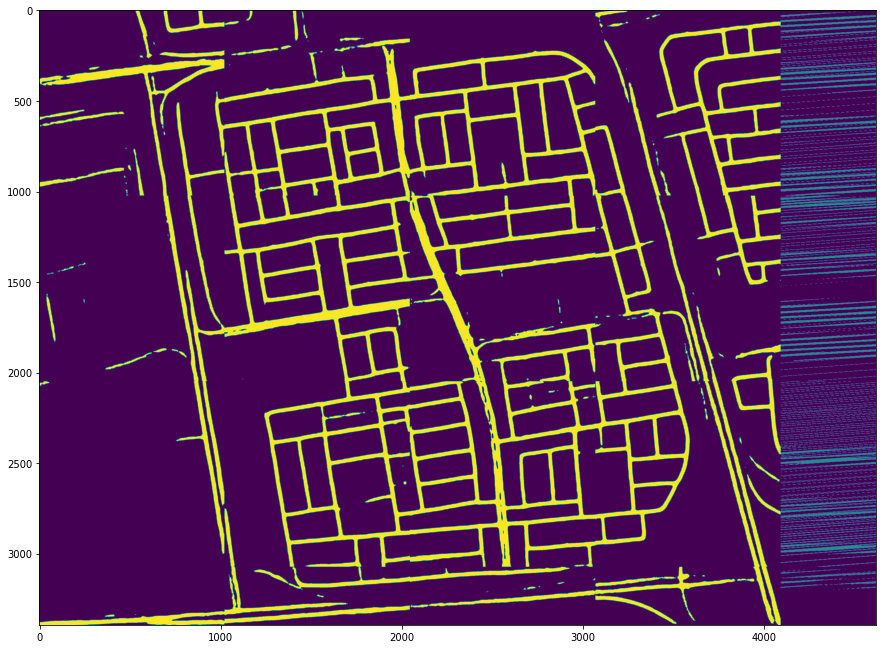

In [120]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(z['tesseract'][0, 0])